# CSE185 Lab 5 Documentation - ChIP-seq

In [ ]:
## 1. Gathering basic stats on data we will be using

cmd = """
wc -l Oct4.esc.fastq
""" # do this for each file and divide line count by 4 to get number of reads
cmd2 = """
cat Oct4.esc.fastq | awk 'NR%4==2 {print length}' | head -n 1
""" # do this for each dataset to get length of reads


## 2. Align each datatbase of reads to reference genome

cmd = """
bwa mem -t 8 ~/public/genomes/GRCm38.fa ~/public/lab5/Oct4.esc.fastq > Oct4.esc.sam
""" # do this for each dataset to align to reference genome

#sort and index each resulted BAM aligned file using samtools 

cmds= """
samtools view -S -b Oct4.esc.sam > Oct4.esc.bam
samtools sort Oct4.esc.bam > Oct4.esc.sorted.bambash: samotols: command not found
samotools sort Oct4.esc.bam > Oct4.esc.sorted.bam
samtools index  Oct4.esc.sorted.bam 
""" # do this for each BAM file


## 3. Find percentage of your reads from each dataset that were successfully aligned

cmd = """
samtools flagstat Oct4.esc.sorted.bam
""" # do this for each *.sorted.bam file

# Create tag directories for each sorted BAM file of each dataset
cmd = """
makeTagDirectory ~/lab5/tagdirs/Oct4 Oct4.esc.sorted.bam
""" # do this for each *.sorted.bam file

## 5. Call peaks for each sample dataset

cmd = """
findPeaks ~/lab5/tagdirs/Oct4 -i ~/lab5/tagdirs/input -style factor -o auto
""" # do this for each transcription factor dataset

cmd = """
findPeaks ~/lab5/tagdirs/H3K27ac -i ~/lab5/tagdirs/input -style histone -o auto
""" # do this for each histone modification dataset

# convert peaks.txt or regions.txt to a bed file
cmd = """
pos2bed.pl Oct4/peaks.txt > Oct4/Oct4.peaks.bed
""" # do this for each transcription factor dataset

cmd2 = """
pos2bed.pl H3K4me2/regions.txt > H3K4me2/H3K4me2.regions.bed
""" # do this for each histone modification dataset




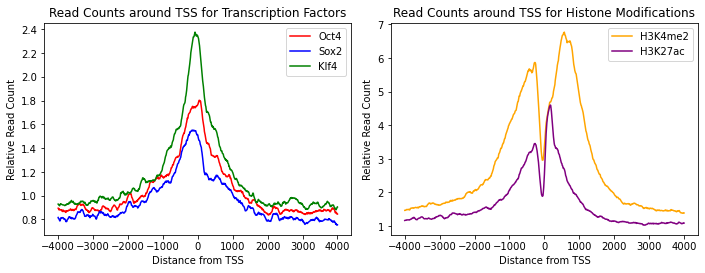

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

## 6. Annotation Peaks and generating composite plot showing distribution of read counts for each dataset around TSSs

# Homer utility tool annotatePeaks.pl to learn where peaks are falling
cmd = """
annotatePeaks.pl tss \
  ~/public/genomes/GRCm38.fa \
  -size 8000 \
  -hist 10 \
  -d ~/lab5/tagdirs/Oct4 ~/lab5/tagdirs/Sox2 ~/lab5/tagdirs/Klf4 ~/lab5/tagdirs/H3K4me2 ~/lab5/tagdirs/H3K27ac \
  -gtf ~/public/genomes/GRCm38.75.gtf > ~/lab5/annotations/tss_histogram.txt
"""


df = pd.read_csv("~/lab5/annotations/tss_histogram.txt", sep = "\t")

distance = "Distance from Center (cmd=annotatePeaks.pl tss /home/atse/public/genomes/GRCm38.fa -size 8000 -hist 10 -d /home/atse/lab5/tagdirs/Oct4 /home/atse/lab5/tagdirs/Sox2 /home/atse/lab5/tagdirs/Klf4 /home/atse/lab5/tagdirs/H3K4me2 /home/atse/lab5/tagdirs/H3K27ac -gtf /home/atse/public/genomes/GRCm38.75.gtf)"

tf_coverage = ["/home/atse/lab5/tagdirs/Oct4 Coverage",
               "/home/atse/lab5/tagdirs/Sox2 Coverage",
               "/home/atse/lab5/tagdirs/Klf4 Coverage"]

histone_coverage = ["/home/atse/lab5/tagdirs/H3K4me2 Coverage",
                    "/home/atse/lab5/tagdirs/H3K27ac Coverage"]

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)

for column, color in zip(tf_coverage, ["red", "blue", "green"]):
    factor = column.split("/")[-1].split()[0]
    ax1.plot(df[distance], df[column], label=factor, color=color)

ax1.set_xlabel("Distance from TSS")
ax1.set_ylabel("Relative Read Count")
ax1.set_title("Read Counts around TSS for Transcription Factors")
ax1.legend()


ax2 = fig.add_subplot(222)


for column, color in zip(histone_coverage, ["orange", "purple"]):
    factor = column.split("/")[-1].split()[0]
    ax2.plot(df[distance], df[column], label=factor, color=color)

ax2.set_xlabel("Distance from TSS")
ax2.set_ylabel("Relative Read Count")
ax2.set_title("Read Counts around TSS for Histone Modifications")
ax2.legend()

plt.tight_layout()
plt.savefig("read_counts_TSS.png", dpi =200)


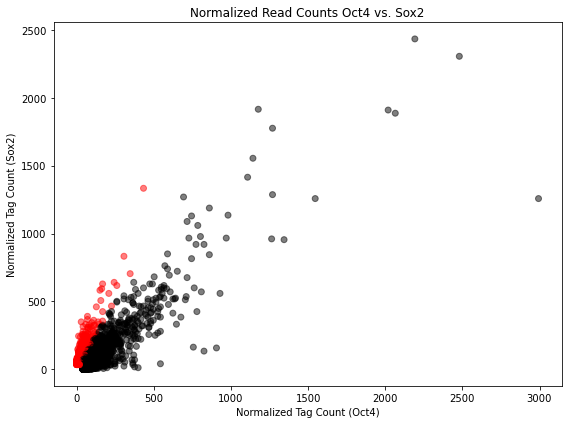

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# 7. Motif finding for each factor

cmd = """
prefix=Sox2
findMotifsGenome.pl \
 ~/lab5/tagdirs/${prefix}/peaks.txt \
 ~/public/genomes/GRCm38.fa \
 ~/lab5/motifs/${prefix} \
 -mask -size 100 -p 6
""" # do this for each TF dataset

# 8. Merge peak sets for Oct4 and Sox and make a scatter plot comparing normalized read counts

cmds = """
mergePeaks ~/lab5/tagdirs/Oct4/peaks.txt ~/lab5/tagdirs/Sox2/peaks.txt > ~/lab5/overlap/oct4_sox2_peaks_merged.txt

annotatePeaks.pl \
   ~/lab5/overlap/oct4_sox2_peaks_merged.txt \
  ~/public/genomes/GRCm38.fa \
  -d ~/lab5/tagdirs/Oct4 ~/lab5/tagdirs/Sox2 > ~/lab5/overlap/oct4_sox2_scatter.txt
"""

overlap = pd.read_csv("/home/atse/lab5/overlap/oct4_sox2_scatter.txt", sep = "\t")

oct4_counts = overlap["/home/atse/lab5/tagdirs/Oct4 Tag Count in given bp (1733716.0 Total, normalization factor = 5.77, effective total = 10000000)"]
sox2_counts = overlap["/home/atse/lab5/tagdirs/Sox2 Tag Count in given bp (1717745.0 Total, normalization factor = 5.82, effective total = 10000000)"]

fold_change = sox2_counts / oct4_counts
highlighted_peaks = fold_change >= 2

fig = plt.figure(figsize=(8, 6))
ax3 = fig.add_subplot(111)

ax3.scatter(oct4_counts, sox2_counts, color = np.where(sox2_counts/oct4_counts >=2, "red", "black"), alpha = 0.5)
ax3.set_xlabel("Normalized Tag Count (Oct4)")
ax3.set_ylabel("Normalized Tag Count (Sox2)")
ax3.set_title("Normalized Read Counts Oct4 vs. Sox2")

plt.tight_layout()
plt.savefig("overlap_scatter.png", dpi =200)


In [79]:
## 9. Repeat motif finding with only the peaks that were unique to Sox2 (fold change >2)

# create new txt file with rows where sox2 foldchange is greather than or equal to 2

fold_change = sox2_counts / oct4_counts

filtered_overlap = overlap[fold_change >=2]

output_file_path = "/home/atse/lab5/overlap/oct4_sox2_filtered.txt"

filtered_overlap.to_csv(output_file_path, sep="\t", index=False)


#run findMotifsGenome.pl on new file
cmd = """
findMotifsGenome.pl ~/lab5/overlap/oct4_sox2_filtered.txt ~/public/genomes/GRCm38.fa ~/lab5/motifs/$Sox2_filtered -mask -size 100
"""
